## Preparing Data From Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/veg_dataset

In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset --force

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 43% 232M/534M [00:02<00:03, 99.5MB/s]
User cancelled operation


In [ ]:
!unzip vegetable-image-dataset.zip -d /content/drive/MyDrive/veg_dataset

Archive:  vegetable-image-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of vegetable-image-dataset.zip or
        vegetable-image-dataset.zip.zip, and cannot find vegetable-image-dataset.zip.ZIP, period.


In [ ]:
!ls /content/drive/MyDrive/veg_dataset

test  train  validation


## Import Library

In [ ]:
!pip install --upgrade tensorflow
!pip install tensorflowjs
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import shutil
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from PIL import Image

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

## Data

In [ ]:
data_path = ('/content/drive/MyDrive/veg_dataset')
train_path = ('/content/drive/MyDrive/veg_dataset/train')
validation_path = ('/content/drive/MyDrive/veg_dataset/validation')
test_path = ('/content/drive/MyDrive/veg_dataset/test')

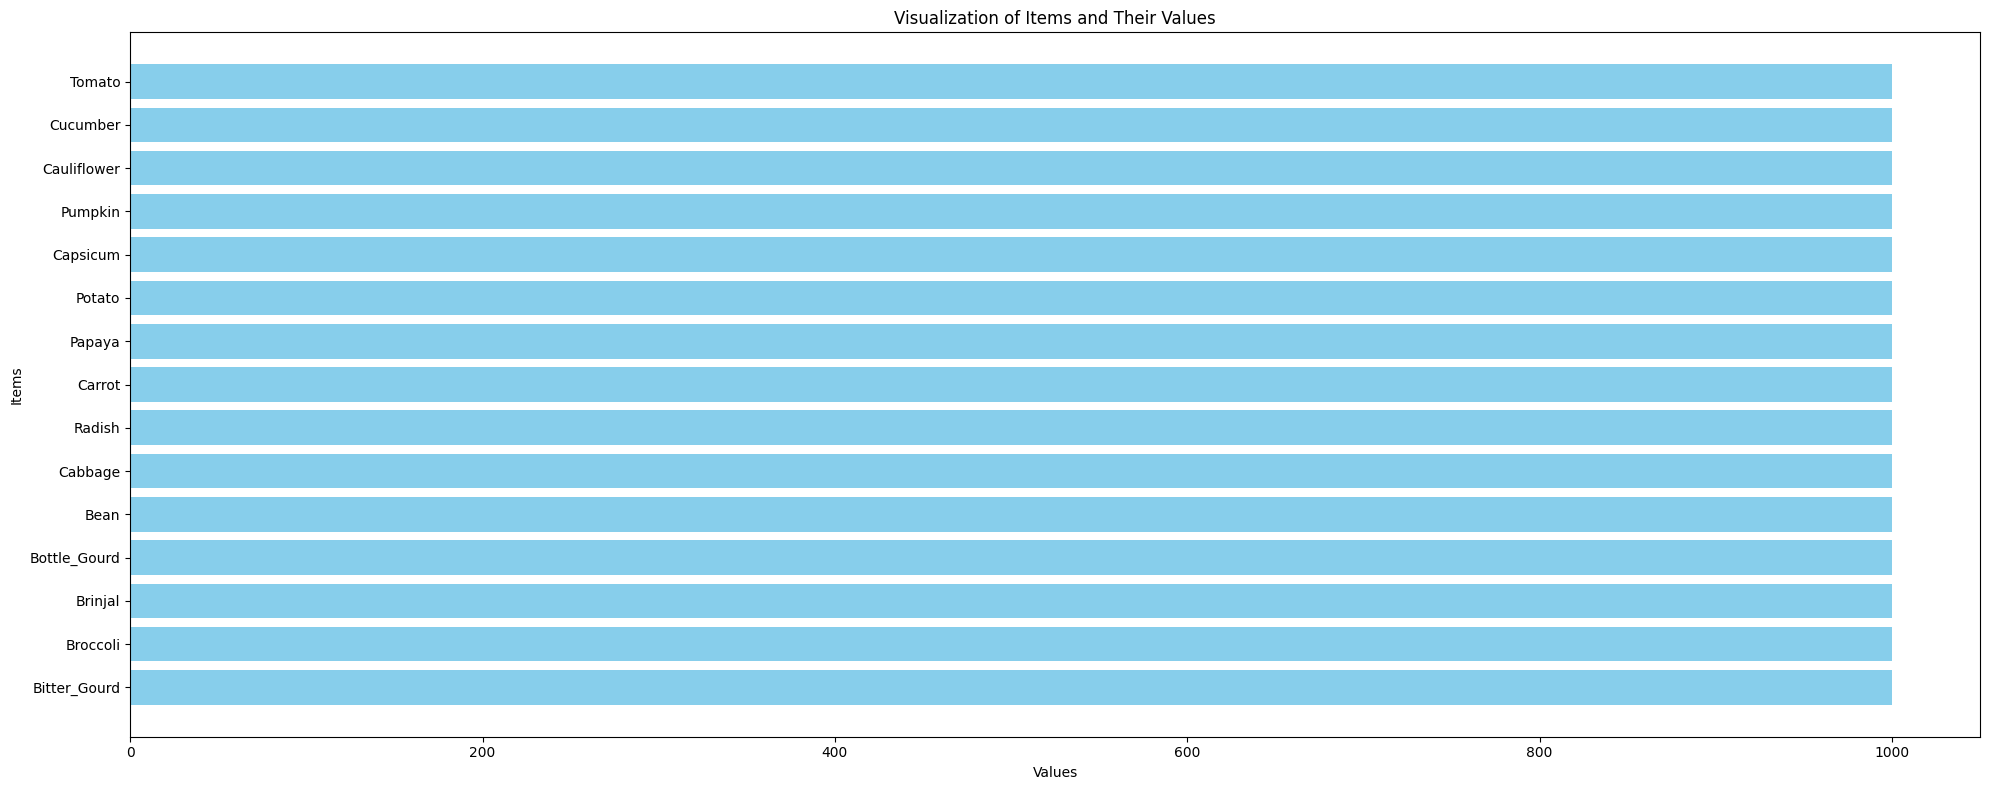

In [ ]:
class_files = os.listdir(train_path)

class_list=[]
for file in class_files:
    path = os.path.join(train_path, file)
    class_list.append((file, len(os.listdir(path))))

# Split data into two lists for plotting
items, values = zip(*class_list)

# Visualize the data as a bar chart
plt.figure(figsize=(20, 8))
plt.barh(items, values, color='skyblue')
plt.xlabel("Values")
plt.ylabel("Items")
plt.title("Visualization of Items and Their Values")
plt.tight_layout()
plt.show()

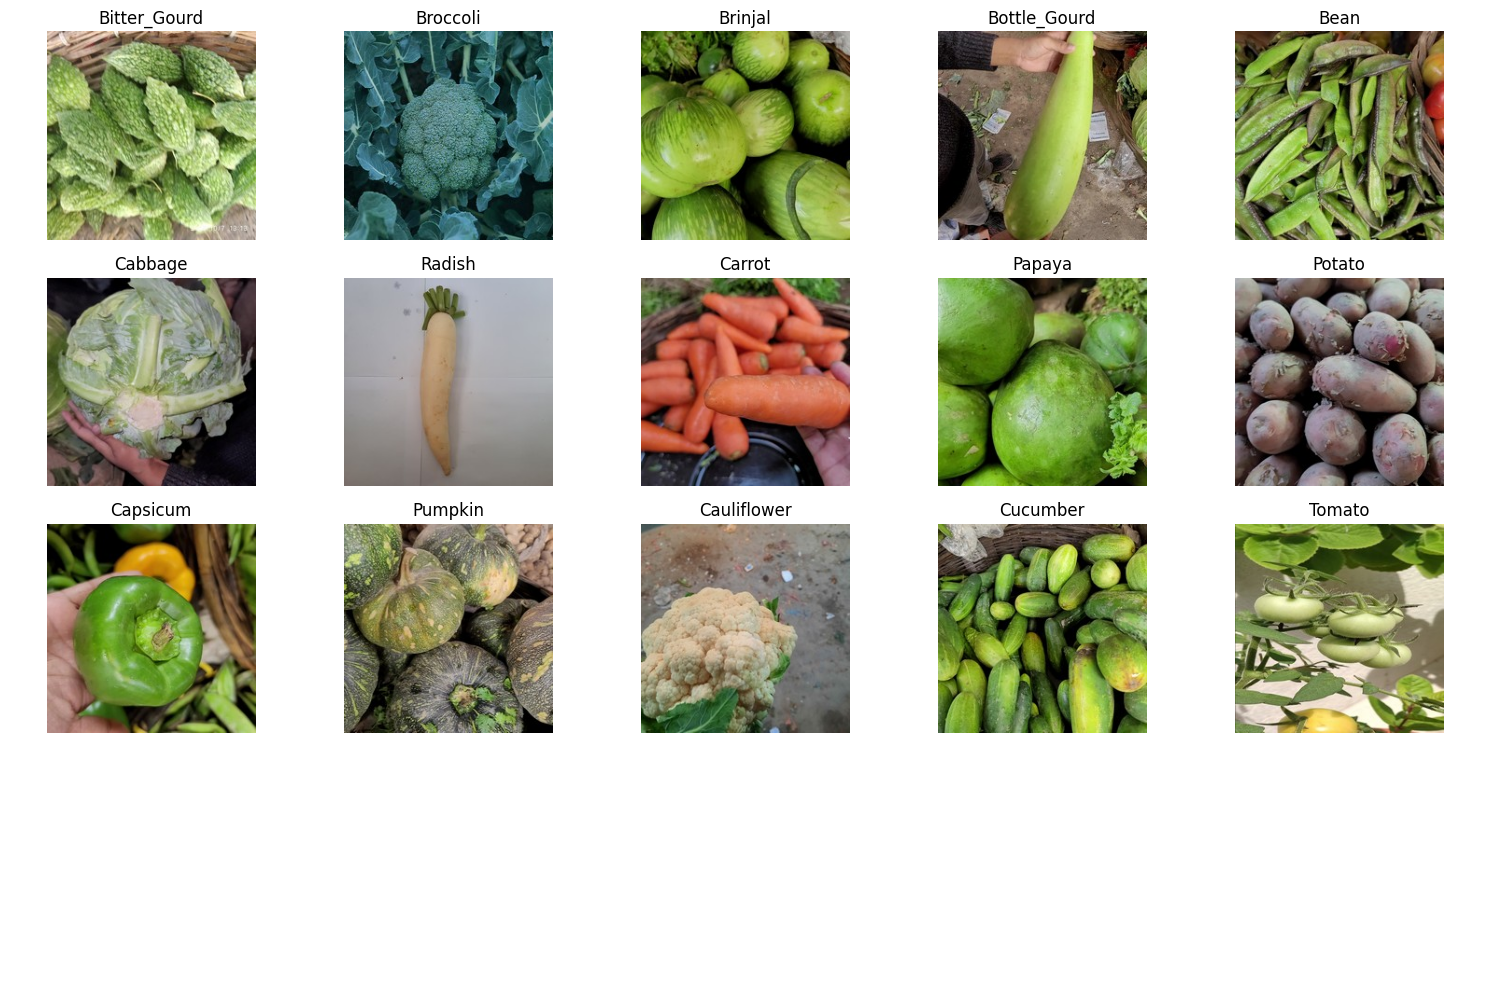

In [ ]:
# Select random images from each class
img_files = []
for file in class_files:
    path = os.path.join(train_path, file)
    imgs = [os.path.join(path, x) for x in os.listdir(path)]
    # Check if the directory contains any images before trying to select one
    if imgs:  # This is equivalent to 'if len(imgs) > 0:'
        img_files.append(imgs[random.randint(0, len(imgs)-1)])
    else:
        print(f"Warning: No images found in directory: {path}")

# Function to display images
def show_images(image_files, cols=5):
    rows = int(len(image_files) / cols) + 1
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    for i, ax in enumerate(axs.flat):
        if i < len(image_files):
            img = mpimg.imread(image_files[i])
            ax.imshow(img)
            ax.set_title(f"{os.path.basename(Path(image_files[i]).parent)}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display the images
show_images(img_files)

In [ ]:
# Check total data
files = 0
for dirpath, dirnames, filenames in os.walk(data_path):
  files += len(filenames)

print(files)

21000


In [ ]:
# Function to check image resolutions
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            if len(unique_sizes) >= 5:
                break
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in list(unique_sizes)[:5]:  # Display 5 unique resolutions
            print(f"- {size}")
        print("---------------")
        unique_sizes.clear()

    display(f"\nTotal: {total_images}")

print_images_resolution(train_path)

Bitter_Gourd: 1000
- (224, 224)
- (224, 193)
- (224, 205)
- (224, 200)
---------------
Broccoli: 1000
- (224, 224)
---------------
Brinjal: 1000
- (224, 224)
---------------
Bottle_Gourd: 1000
- (224, 224)
---------------
Bean: 1000
- (224, 224)
---------------
Cabbage: 1000
- (224, 224)
---------------
Radish: 1000
- (224, 224)
---------------
Carrot: 1000
- (224, 224)
---------------
Papaya: 1000
- (224, 224)
- (224, 198)
- (224, 210)
- (224, 211)
---------------
Potato: 1000
- (224, 224)
---------------
Capsicum: 1000
- (224, 224)
---------------
Pumpkin: 1000
- (224, 224)
---------------
Cauliflower: 1000
- (224, 224)
---------------
Cucumber: 1000
- (224, 224)
---------------
Tomato: 1000
- (224, 224)
---------------


'\nTotal: 15000'

## Preprocessing Data

### Split Train Test Ratio

In [ ]:
# Check dataset split ratio
def check_split_ratio(train_dir, test_dir, ratio=0.8):
    train_count = sum([len(files) for _, _, files in os.walk(train_dir)])
    test_count = sum([len(files) for _, _, files in os.walk(test_dir)])
    total_count = train_count + test_count

    train_ratio = train_count / total_count
    test_ratio = test_count / total_count

    print(f"Training data: {train_count} ({train_ratio:.2%})")
    print(f"Testing data: {test_count} ({test_ratio:.2%})")

    # if abs(train_ratio - ratio) < 0.01 and abs(test_ratio - (1 - ratio)) < 0.01:
    #     print("The dataset split matches the expected ratio.")
    # else:
    #     print("The dataset split does not match the expected ratio.")

# Example usage
check_split_ratio(train_path, test_path)

Training data: 15000 (83.33%)
Testing data: 3000 (16.67%)


In [ ]:
# Setup data inputs
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerator objects
train_datagen = ImageDataGenerator(rescale = 1/255.)
validation_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Create data flows
print("Train data:")
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size = IMAGE_SHAPE,
                                               shuffle = True,
                                               batch_size = BATCH_SIZE)

print("Validation data:")
validation_data = train_datagen.flow_from_directory(validation_path,
                                                    target_size = IMAGE_SHAPE,
                                                    batch_size = BATCH_SIZE)

print("Test data")
test_data = test_datagen.flow_from_directory(test_path,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE)

Train data:
Found 15000 images belonging to 15 classes.
Validation data:
Found 3000 images belonging to 15 classes.
Test data
Found 3000 images belonging to 15 classes.


## Model

### Sequential

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(15, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=10,
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 109, 109, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 111s 115ms/step - accuracy: 0.4855 - loss: 1.7449 - val_accuracy: 0.7447 - val_loss: 0.8075 - learning_rate: 0.0010
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 134s 108ms/step - accuracy: 0.8126 - loss: 0.6067 - val_accuracy: 0.8930 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 136s 103ms/step - accuracy: 0.8867 - loss: 0.3796 - val_accuracy: 0.8523 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 103ms/step - accuracy: 0.9142 - loss: 0.2749 - val_accuracy: 0.8647 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 97s 102ms/step - accuracy: 0.9656 - loss: 0.1069 - val_accuracy: 0.9380 - val_loss: 0.2631 - learning_rate: 2.0000e-04
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 145s 106ms/step - accuracy: 0.9860 - loss: 0.0471 - val_accuracy: 0.9387 - val_loss: 0.2507 - learning_rate: 2.0000e-04
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 105s 111ms/step - 

### Plot Accuracy & Loss Model

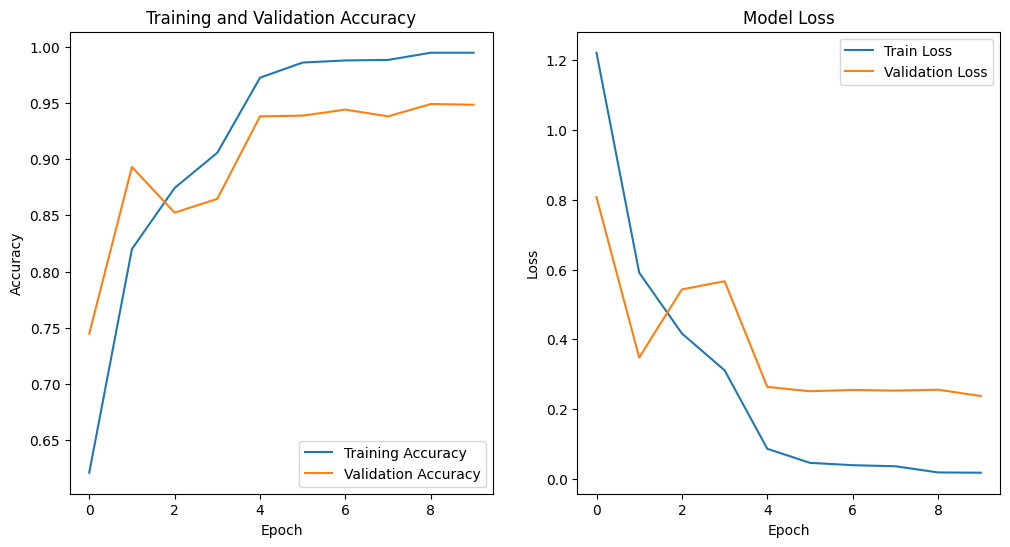

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Evaluate the model on the test set
results = model.evaluate(test_data, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")

Test Loss: 0.14637
Test Accuracy: 95.43%


## Save Result Model

In [ ]:
baseDir = '/content/drive/My Drive/models/'
DIR = '/content/drive/My Drive/models'

os.makedirs(baseDir, exist_ok=True)

### Saved Model & TFJS

In [ ]:
# Define paths
train_path = '/content/drive/MyDrive/veg_dataset/train'
save_model_dir = '/content/drive/MyDrive/models/'

# Extract class names from the directory structure
class_names = sorted(os.listdir(train_path))
print(f"Class Names: {class_names}")

# Save the labels to a text file
labels_path = os.path.join(save_model_dir, 'labels.txt')
with open(labels_path, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

print(f"Labels saved successfully to {labels_path}")

# Save the model in the Keras format
model.save(os.path.join(save_model_dir, 'my_model.keras'))

# Alternatively, save the model in the H5 format
model.save(os.path.join(save_model_dir, 'my_model.h5'))

# Save the model in the SavedModel format
tf.saved_model.save(model, os.path.join(save_model_dir, 'my_model'))

# Convert the model to TensorFlow.js format
tfjs.converters.save_keras_model(model, os.path.join(save_model_dir, 'my_model_tfjs'))

print("Model and labels saved successfully.")

Class Names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Labels saved successfully to /content/drive/MyDrive/models/labels.txt


failed to lookup keras version from the file,
    this is likely a weight only file
Model and labels saved successfully.


### TFLite

In [ ]:
# Load the Keras model
save_model_dir = '/content/drive/MyDrive/models/'
keras_model_path = os.path.join(save_model_dir, 'my_model.keras')
model = tf.keras.models.load_model(keras_model_path)

# Convert the model to TFLite format from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to disk
tflite_model_path = os.path.join(save_model_dir, 'my_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved successfully after converting from Keras model.")

Saved artifact at '/tmp/tmpc6ztapvi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  136555786013856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555786019312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555935063504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555935065616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555935058928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555935061216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555935065264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555937080144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555937081904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136555937083664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13655593707891

## Inference

In [ ]:
interpreter = tf.lite.Interpreter('/content/drive/MyDrive/models/my_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load labels
with open('/content/drive/MyDrive/models/labels.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

def preprocess_image(image_path):
    import cv2
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
image_path = '/content/drive/MyDrive/veg_dataset/test/Pumpkin/1001.jpg'
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: Pumpkin
